<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/LotkaVolterra_full_GRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci

In [9]:
import seaborn as sns
import random

from scipy import signal
from ipywidgets import interact
import ipywidgets as widgets
%matplotlib inline
# sns.set_style("whitegrid")
sns.set_style("darkgrid")
sns.set_context("paper")

\begin{align}
    \dot{u} &= u(1-v) \\
    \dot{v} &= \beta\ v(u-1)
\end{align}

In [16]:
def dS_LT(S, beta1):
    u, v = S
    du = u*(1 - v)
    dv = beta1*v*(u - 1)

    dS = np.asarray([du, dv])
    return dS

def supr(e, n, s):
    return e/(1 + s**n)

In [17]:
def RK4_LotkaVolterra(t, S0, beta1):
    dims = len(S0)
    K = np.empty([4, dims])
    S = np.zeros([2*len(t)+1, dims])

    for d in range(dims):
        S[0, d] = S0[d]

    dt = t[1] - t[0];
    for i in range(len(t)):
        K[0] = dt * dS_LT(S[i]         , beta1)
        K[1] = dt * dS_LT(S[i] + K[0]/2, beta1)
        K[2] = dt * dS_LT(S[i] + K[1]/2, beta1)
        K[3] = dt * dS_LT(S[i] + K[2]  , beta1)
        for d in range(dims):
            S[i+1, d] = S[i, d] + (K[0,d]+2*K[1,d]+2*K[2,d]+K[3,d])/6
    return S[1:len(t)+2, :]

In [18]:
def X(t, A, n, T):
    x1 = (A*(1 + np.sin(2*np.pi*t/T)))**n
    x2 = (A*(1 + np.cos(2*np.pi*t/T)))**n
    return np.array([x1, x2])

def Y(t, A, n, beta):
    y1 = (A*(1 + np.sin(t*np.sqrt(beta))))**n
    y2 = (A*(1 + np.cos(t*np.sqrt(beta))))**n
    return np.array([y1, y2])

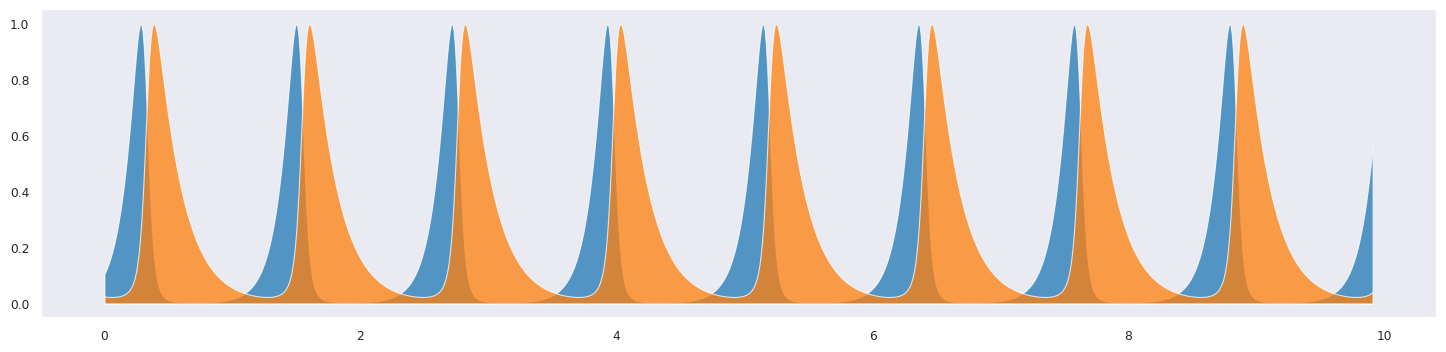

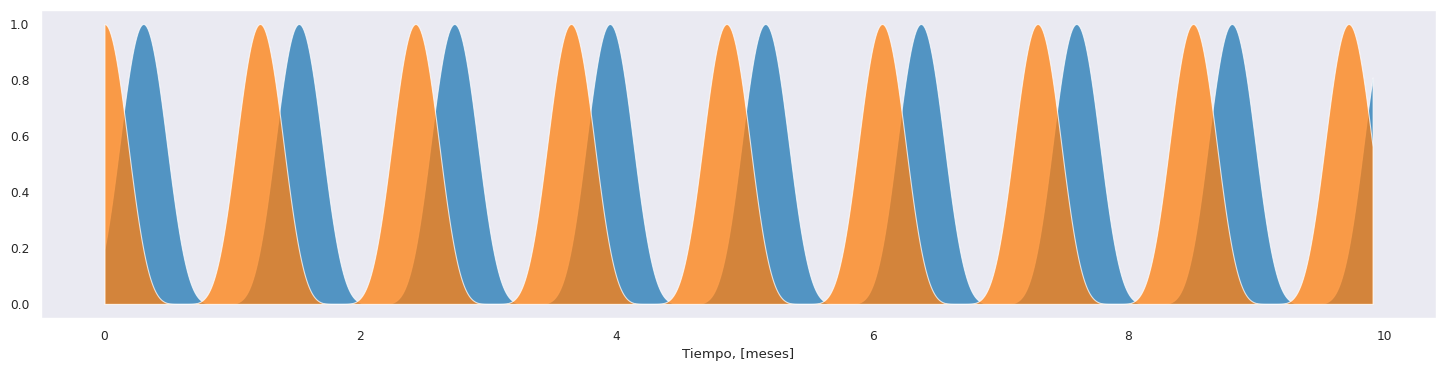

In [19]:
# Parámetros
u = .5;
v = .1;
# beta = 0.4568;
beta1, beta2 = 0.51, 0.263;
# t_begin=0*np.pi; t_end=170*np.pi; num=48000
t_begin=0*np.pi; t_end=4800; num=48000
t = np.linspace(t_begin, t_end, num)
ut, ut_label = 0.099164, "meses"
# ut, ut_label = 3.016241, "dias"

S0 = np.array([u, v])
Pip = RK4_LotkaVolterra(t, S0, beta1)
X1_LT, X2_LT= Pip[1:,0], Pip[1:,1]

plt.figure(figsize=(18,4), dpi=100)
plt.fill_between(ut * t[:1000], X1_LT[:1000]/np.max(X1_LT), alpha=0.75)
plt.fill_between(ut * t[:1000], X2_LT[:1000]/np.max(X2_LT), alpha=0.75)
# plt.xlim(t_begin*ut, t_end*ut);
plt.grid()

# -----------------

x1, x2 = X(t, 0.5, 2.36, 12.25)
yy1, yy2 = Y(t, 0.5, 2.36, beta2)

plt.figure(figsize=(18,4), dpi=100)
plt.fill_between(ut * t[:1000], x1[:1000], alpha=0.75, label="(TNFa)");
# plt.fill_between(t*ut, x2, alpha=0.75, label="(TGFb1)");
plt.fill_between(ut * t[:1000], yy2[:1000], alpha=0.75, label="(TGFb1)");
# plt.xlim(t_begin*ut, t_end*ut);
plt.xlabel(f"Tiempo, [{ut_label}]"); plt.grid()

# plt.ylabel("Amplitud, [ua]")
# plt.text(100, 1.2, f"  Ciclo de activacion de citocinas en Páncreas", va='center', fontsize=16)

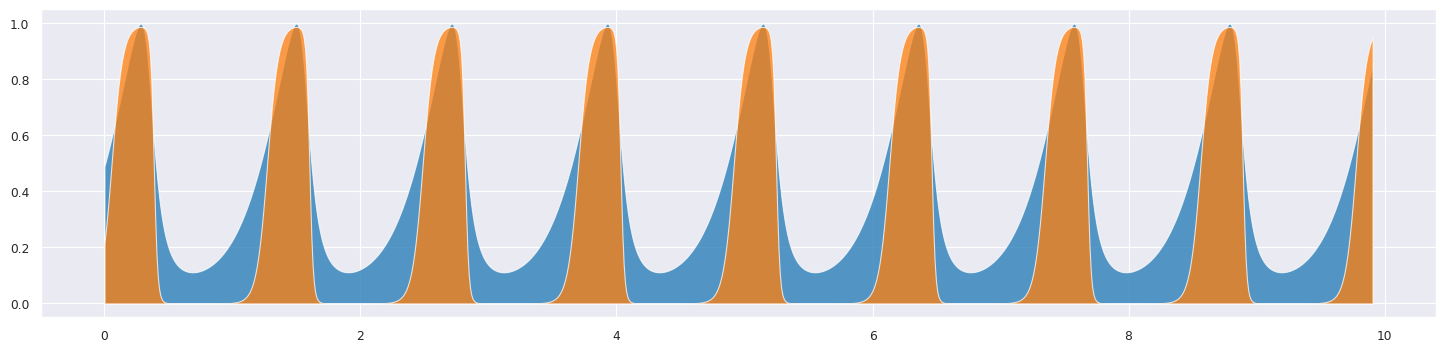

In [73]:
plt.figure(figsize=(18,4), dpi=100)
plt.fill_between(ut * t[:1000], supr(2, -0.5, X1_LT[:1000]/np.max(X1_LT)), alpha=0.75, label="(TNFa)");
# plt.fill_between(ut * t[:1000], supr(1, -0.5, X2_LT[:1000]), alpha=0.75, label="(TNFa)");
plt.fill_between(ut * t[:1000], supr(1, -2.53, X1_LT[:1000]), alpha=0.75, label="(TNFa)");
# plt.fill_between(ut * t[:1000], supr(1, 0.5, X2_LT[:1000]), alpha=0.75, label="(TNFa)");

In [23]:
def RK_solver(S0, t, tau1, tau2, X1, X2):
    dims = len(S0)
    K = np.empty([4, dims])
    S = np.zeros([2*len(t)+1, dims])

    for d in range(dims):
        S[0, d] = S0[d]

    dt = t[1] - t[0];
    for i in range(len(t)):
        y1_tau1, c3_tau2 = S[i-int(tau1), 0], S[i-int(tau2), 5]
        K[0] = dt * dS(S[i]         , i, y1_tau1, c3_tau2, X1, X2)
        K[1] = dt * dS(S[i] + K[0]/2, i, y1_tau1, c3_tau2, X1, X2)
        K[2] = dt * dS(S[i] + K[1]/2, i, y1_tau1, c3_tau2, X1, X2)
        K[3] = dt * dS(S[i] + K[2]  , i, y1_tau1, c3_tau2, X1, X2)
        for d in range(dims):
            S[i+1, d] = S[i, d] + (K[0,d]+2*K[1,d]+2*K[2,d]+K[3,d])/6
    return S[1:len(t)+2, :]

In [99]:
def dS(S, i, y1_tau1, c3_tau2, X1, X2):
    y1, y2, y3, y4, c1, c2, c3, c4, z1, z2, z3, z4, Ry1, Ry2, Ry3, Ry4, Rc1, Rc2, Rc3, Rc4, Rz1, Rz2, Rz3, Rz4, Rc2a, Rc2b, c2a, c2b = S
    # --------------------------------------------------------
    dRy1 = e[0]*(supr(1, n[0], X1[i]) + supr(1, n[0], y1_tau1) + supr(1, n[0], y3) + supr(1, n[0], y4) + supr(0.015, n[0], c3_tau2)) - Ry1;
    dy1  = supr(1, n[1], Ry1) - y1;                                           # RAS

    dRy2 = e[1]*(supr(1, n[0], y1) + supr(1, -n[0], y2) + supr(1, -n[0], y3)) - Ry2;
    dy2  = supr(1, n[1], Ry2) - y2;                                           # P53

    dRy3 = e[2]*(supr(1, n[0], y4) + supr(1, -n[0], y2)) - Ry3;
    dy3  = supr(1, n[1], Ry3) - y3;                                           # PIP3

    dRy4 = e[3]*(supr(1, n[0], X2[i]) + supr(1, n[0], y1)) - Ry4;
    dy4  = supr(1, n[1], Ry4) - y4;                                           # ERK
    # --------------------------------------------------------
    # dRc1 = e[4]*(supr(1, n[0], y1_tau1) + supr(1, n[0], c3) + supr(2, -n[0], c2)) - Rc1
    dRc1 = e[4]*(supr(1, n[0], y1_tau1) + supr(1, n[0], c3_tau2) + supr(2, -n[0], c2)) - Rc1
    dc1  = supr(1, n[1], Rc1) - c1;                                           # BCL-XL

    # dRc2a = e[5]*(supr(1, -n[0], c2) + supr(1, -n[0], c3)) - Rc2a;
    dRc2a = e[5]*(supr(1, -n[0], c2) + supr(1, -n[0], c3_tau2)) - Rc2a;
    dc2a  = supr(1, n[1], Rc2a) - c2a;
    # dRc2b = e[6]*(supr(1, +n[0], c3) + supr(1, -n[0], c4)) - Rc2b;
    dRc2b = e[6]*(supr(1, +n[0], c3_tau2) + supr(1, -n[0], c4)) - Rc2b;
    dc2b  = supr(1, n[1], Rc2b) - c2b;
    dRc2 = e[7]*(supr(1, n[0], c2a) + supr(1, n[0], c2b)) - Rc2;
    dc2  = supr(1, n[1], Rc2) - c2;                                           # P53c

    dRc3 = e[8]*(supr(1, n[0], y1_tau1) + supr(1, -n[0], c2)) - Rc3;
    dc3  = supr(1, n[1], Rc3) - c3;                                           # PIP3c

    dRc4 = e[9]*(supr(1, n[0], X2[i]) + supr(1, n[0], c2)) - Rc4;
    dc4  = supr(1, n[1], Rc4) - c4;                                           # P21
    # --------------------------------------------------------
    dRz2 = e[10]*(supr(1, -n[0], y2) + supr(1, n[0], y4)) - Rz2;
    dz2  = supr(1, n[1], Rz2) - z2;

    dRz3 = e[11]*(supr(1, -n[0], c3_tau2) * (supr(1, n[0], c2) + supr(1, -n[0], c1)) * supr(0.5, -n[0], z3)) - Rz3
    # dRz3 = e[11]*(supr(1, -n[0], c3) * (supr(1, n[0], c2) + supr(1, -n[0], c1)) * supr(0.5, -n[0], z3)) - Rz3
    # dRz3 = e[11]*(supr(2, -n[0], c3) + supr(1, n[0], c2) + supr(1, -n[0], c1)) - Rz3
    dz3  = supr(1, n[1], Rz3) - z3;

    dRz4 = e[12]*(supr(1, n[0], y1_tau1) + supr(1, n[0], c3_tau2) + supr(1, -n[0], c4)) - Rz4
    dz4  = supr(1, n[1], Rz4) - z4;
    # --------------------------------------------------------
    dS = [dy1, dy2, dy3, dy4, dc1, dc2, dc3, dc4, dy2, dz2, dz3, dz4, dRy1, dRy2, dRy3, dRy4, dRc1, dRc2, dRc3, dRc4, dRy2, dRz2, dRz3, dRz4, dRc2a, dRc2b, dc2a, dc2b]
    return np.array(dS)

In [157]:
# parámetros
n = [-6, -10]
e = [1/0.3, 1/2.2, 1/1, 1/0.3, 1/1.25, 1/1.4, 1/1.0, 1/0.2, 1/1, 1/1, 1/1.05, 1/0.68, 1/1.4]
start=0; step=0.1; num=40800
t = np.arange(0.0001, num)*step + start

S0 = np.concatenate([np.array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1]), np.zeros(18)])   # Y, C, Z, R
# print(t[0], t[1]-t[0], t[-1])

In [160]:
labels = ["RAS","P53","PIP3","ERK","BCL-XL","P53c","PIP3c","P21","ApopS","ProlifS","ApopC","ProlifC"]

def plot_full_GRN(tau1, tau2, n_exp):
    tt = t; ut = 0.099164
    # X1, X2 = X1_LT**n_exp, X2_LT**n_exp
    X1, X2 = supr(1, -n_exp/10, X1_LT), supr(1, -n_exp/10, X2_LT)
    # X1, X2 = supr(2, -n_exp/10, X1_LT/np.max(X1_LT)*1.2), supr(2, -n_exp/10, X2_LT/np.max(X2_LT)*1.2)

    Pip = RK_solver(S0, t, tau1, tau2, X1, X2)
    fig = plt.figure(figsize=(18,8), dpi=100); gs = fig.add_gridspec(3, hspace=0.05)
    axs = gs.subplots()


    for i in range(4):
        axs[0].plot(t*ut, Pip[1:,i]  , label=labels[i],   linewidth=0.5)
        axs[1].plot(t*ut, Pip[1:,i+4], label=labels[i+4], linewidth=0.5)
        axs[2].plot(t*ut, Pip[1:,i+8], label=labels[i+8], linewidth=0.5)
    axs[0].legend(loc="upper left", bbox_to_anchor=(0.924, 0.85)); axs[0].set_xlim([tt[0], tt[-1]*ut]);  axs[0].set_ylim([-0.05, 1.05])
    # axs[0].axvline(tau1/10*ut, color="black");
    axs[0].axvline(tau2/10*ut, color="black"); axs[0].axvline(tau2/10*ut + (tau2)*0.08*ut, color="black")

    axs[1].legend(loc="upper left", bbox_to_anchor=(0.924, 0.85)); axs[1].set_xlim([tt[0], tt[-1]*ut]);  axs[1].set_ylim([-0.05, 1.05])
    # axs[1].axvline(tau1/10*ut, color="black");
    axs[1].axvline(tau2/10*ut, color="black"); axs[1].axvline(tau2/10*ut + (tau2)*0.08*ut, color="black")

    axs[2].legend(loc="upper left", bbox_to_anchor=(0.924, 0.85)); axs[2].set_xlim([tt[0], tt[-1]*ut]);  axs[2].set_ylim([-0.05, 1.05])
    # axs[2].axvline(tau1/10*ut, color="black");
    axs[2].axvline(tau2/10*ut, color="black"); axs[2].axvline(tau2/10*ut + (tau2)*0.08*ut, color="black")
    fig.text(0.35, 0.91, "  Perfil de expresión genética en Cáncer de Páncreas\n" +
             f"$T = {round(2*np.pi*1.95*3.016241,2)}$ días,   $\Delta t_1 = {round((tau2)*step*3.016241,1)}$ días,   $\Delta t_2 = {round((tau2)*0.8*step*3.016241,1)}$ días",
            va='center', fontsize=16)

    plt.xlabel(r"Tiempo [meses]", fontsize=12)
    fig.text(0.09, 0.5, r"Amplitud, [ua]", va='center', rotation='vertical', fontsize=12)
    plt.show()

In [161]:
interact(plot_full_GRN,
# interact(plot_full_GRN, beta = widgets.FloatSlider(value=0.263, min=0.1, max=1, step=0.01),
                     tau1 = widgets.FloatSlider(value=1584, min=100, max=5000, step=0.1),
                     tau2 = widgets.FloatSlider(value=20870, min=15000, max=25000, step=1),
                    n_exp = widgets.FloatSlider(value=25.5, min=1, max=35, step=0.1))

interactive(children=(FloatSlider(value=1584.0, description='tau1', max=5000.0, min=100.0), FloatSlider(value=…

<function __main__.plot_full_GRN(tau1, tau2, n_exp)>